In [2]:
# Import necessary libraries
import pandas as pd
import os
import numpy as np
import json
import re
from collections import Counter
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
import plotly.express as px
from scipy.stats import sem, mannwhitneyu


In [3]:
# Define the path to the preprocessed data
preprocessed_file_path = 'preprocessed_movies.parquet'  # Ensure this path matches where you saved the file

# Check if the preprocessed file exists
if not os.path.isfile(preprocessed_file_path):
    raise FileNotFoundError(f"Preprocessed file not found at {preprocessed_file_path}")

print(f"Loading preprocessed data from {preprocessed_file_path}...")
df_movies = pd.read_parquet(preprocessed_file_path)
print(f"Data loaded successfully. Total movies: {df_movies.shape[0]}")

# Convert release date to a datetime if not already
df_movies['Movie_release_date'] = pd.to_datetime(df_movies['Movie_release_date'], errors='coerce')



Loading preprocessed data from preprocessed_movies.parquet...
Data loaded successfully. Total movies: 37489


In [4]:

df_movies.rename(columns={'Movie_countxries': 'Movie_countries'}, inplace=True)

mapping = {
    'Hong Kong': 'China',
    'West Germany': 'Germany',
    'Soviet Union': 'Russia',
    'Czechoslovakia': 'Czechia',
    'German Democratic Republic': 'Germany',
    'Yugoslavia': 'Serbia',
    'England': 'United Kingdom',
    'Weimar Republic': 'Germany',
    'Scotland': 'United Kingdom',
    'Korea': 'South Korea',
    'Burma': 'Myanmar',
    'Nazi Germany': 'Germany',
    'Republic of Macedonia': 'North Macedonia',
    'Socialist Federal Republic of Yugoslavia': 'Serbia',
    'Serbia and Montenegro': 'Serbia',
    'Kingdom of Great Britain': 'United Kingdom',
    'Federal Republic of Yugoslavia': 'Serbia',
    'Georgian SSR': 'Georgia',
    'Palestinian territories': 'Palestine',
    'Slovak Republic': 'Slovakia',
    'Mandatory Palestine': 'Palestine',
    'Uzbek SSR': 'Uzbekistan',
    'Wales': 'United Kingdom',
    'Northern Ireland': 'United Kingdom',
    'Ukranian SSR': 'Ukraine',
    'Isle of Man': 'United Kingdom',
    'Soviet occupation zone': 'Germany',
    'Malayalam Language': 'India',  # Language, assuming tied to India
    'Crime': 'Ukraine',  # Not clear, omitted
    'Iraqi Kurdistan': 'Iraq',
    'German Language': 'Germany',  # Language, assuming tied to Germany
    'Palestinian Territories': 'Palestine',
    'Kingdom of Italy': 'Italy',
    'Ukrainian SSR' : 'Ukraine',
    'Republic of China' : 'China',
    'Makau' : 'China',
    'Aruba' : 'Netherlands'
}

df_movies["Movie_countries"] = df_movies["Movie_countries"].apply(lambda x: list(json.loads(x).values()))
df_movies["Movie_countries"] = df_movies["Movie_countries"].apply(
    lambda countries: [mapping.get(country, country) for country in countries]
)


In [5]:

# Drop rows without Clean_Summary or where Clean_Summary is too short
df_movies = df_movies.dropna(subset=['Clean_Summary'])
df_movies = df_movies[df_movies['Clean_Summary'].str.strip() != ""]


# Assume df_movies["Clean_Summary"] contains cleaned summaries as strings
# First, tokenize each summary into a list of words:
df_movies["tokens"] = df_movies["Clean_Summary"].apply(lambda x: x.split())

# Count how often each word appears across all documents
word_counts = Counter(word for tokens in df_movies["tokens"] for word in tokens)

# Compute how many documents each word appears in:
word_in_docs = {}
for tokens in df_movies["tokens"]:
    unique_tokens = set(tokens)
    for token in unique_tokens:
        word_in_docs[token] = word_in_docs.get(token, 0) + 1

# Decide thresholds:
# Example: too_common_threshold: words that appear in more than 50% of documents
too_common_threshold = 0.5 * len(df_movies)
# Example: too_rare_threshold: words that appear in fewer than 5 documents
too_rare_threshold = 5

too_common_words = {w for w, count in word_in_docs.items() if count > too_common_threshold}
too_rare_words = {w for w, count in word_in_docs.items() if count < too_rare_threshold}
df_movies["tokens_filtered"] = df_movies["tokens"].apply(
    lambda tokens: [w for w in tokens if #w not in too_common_words and
                     w not in too_rare_words]
)
df_movies=df_movies[['Wikipedia_movie_ID',	'Movie_name',	'Movie_countries',	'Movie_release_date',	'Female Percentage',	'tokens_filtered']]

In [6]:
df=df_movies
df.head()

,Wikipedia_movie_ID,Movie_name,Movie_countries,Movie_release_date,Female Percentage,tokens_filtered
0,975900,Ghosts of Mars,[United States of America],2001-08-24,35.294118,"[set, second, half, nd, century, depict, mar, ..."
1,9363483,White Of The Eye,[United Kingdom],NaT,50.000000,"[series, murder, rich, young, woman, arizona, ..."
2,261236,A Woman in Flames,[Germany],NaT,33.333333,"[eva, upper, class, housewife, frustrated, lea..."
3,18998739,The Sorcerer's Apprentice,[South Africa],NaT,20.000000,"[year, evil, morgana, return, claim, talisman,..."
4,6631279,Little city,[United States of America],1997-04-04,66.666667,"[adam, san, artist, work, cab, driver, hard, t..."


In [7]:
# Initialize the progress bar for pandas apply operations
tqdm.pandas()
# --- Define Categories and Seed Words ---
# Define seed words for each category as sets for faster lookup

love_words = {
    "love", "romance", "affection", "adore", "loving", "cherish", "passion",
    "attraction", "intimacy", "devotion"
}

aggression_words = {
    "aggression", "anger", "hostile", "rage", "fury", "wrath", "irritation", 
    "belligerence", "antagonism", "resentment"
}

violence_words = {
    "murder", "kill", "violence", "attack", "weapon", "war", "brutal", "bloodshed", 
    "assault", "slaughter"
}

family_words = {
    "family", "mother", "father", "brother", "sister", "child", "children", 
    "daughter", "son", "parent"
}

happiness_words = {
    "happy", "joy", "pleasure", "delight", "glad", "cheerful", "elated", 
    "content", "bright", "optimistic"
}

sadness_words = {
    "sad", "sorrow", "grief", "melancholy", "depressed", "downcast", "tearful", 
    "unhappy", "miserable", "lament"
}

fear_words = {
    "fear", "scared", "frightened", "afraid", "terrified", "anxious", "uneasy", 
    "wary", "alarmed", "panic"
}

empowerment_words = {
    "empower", "empowered", "empowering", "independent", "strong", "leadership",
    "authority", "self-reliant", "resilient", "determined"
}

relationships_words = {
    "friendship", "friend", "friends", "romance", "romantic", "relationship",
    "partner", "partners", "mentorship", "mentor"
}

career_words = {
    "career", "profession", "job", "work", "office", "business", "entrepreneur",
    "startup", "manager", "lead"
}

social_issues_words = {
    "feminism", "equality", "diversity", "activism", "social justice",
    "discrimination", "inclusion", "rights", "empowerment", "advocacy"
}

emotional_complexity_words = {
    "anxiety", "hope", "despair", "joy", "grief", "anticipation", "surprise",
    "trust", "disgust", "anticipate"
}

heroism_words = {
    "hero", "heroic", "sacrifice", "courage", "bravery", "valor", "chivalry",
    "noble", "selfless", "altruism"
}

conflict_resolution_words = {
    "conflict", "resolve", "resolution", "battle", "fight", "struggle",
    "tension", "dispute", "argument", "clash"
}

adventure_words = {
    "adventure", "exploration", "journey", "quest", "voyage", "expedition",
    "trek", "odyssey", "discover", "explore"
}

mystery_words = {
    "mystery", "suspense", "intrigue", "secret", "unknown", "puzzle",
    "enigma", "clue", "detective", "investigation"
}

technology_words = {
    "technology", "innovate", "innovation", "science", "future", "robot",
    "AI", "artificial intelligence", "cyber", "digital"
}

# Combine all sentiment categories into a master dictionary
categories = {
    "love_score": love_words,
    "aggression_score": aggression_words,
    "violence_score": violence_words,
    "family_score": family_words,
    "happiness_score": happiness_words,
    "sadness_score": sadness_words,
    "fear_score": fear_words,
    "empowerment_score": empowerment_words,
    "relationships_score": relationships_words,
    "career_score": career_words,
    "social_issues_score": social_issues_words,
    "emotional_complexity_score": emotional_complexity_words,
    "heroism_score": heroism_words,
    "conflict_resolution_score": conflict_resolution_words,
    "adventure_score": adventure_words,
    "mystery_score": mystery_words,
    "technology_score": technology_words
}


In [8]:
# --- Load the Embedding Model ---
print("Loading the embedding model...")
model = SentenceTransformer("all-MiniLM-L6-v2")


Loading the embedding model...


In [9]:
# --- Compute Centroid Embeddings for Each Category ---
print("Computing category centroids...")
category_centroids = {}
for cat, seed_words in categories.items():
    if not seed_words:
        print(f"Warning: No seed words provided for category '{cat}'. Skipping.")
        continue
    seed_embeddings = model.encode(list(seed_words), batch_size=32, show_progress_bar=False)
    centroid = np.mean(seed_embeddings, axis=0)  # shape: (embedding_dim,)
    category_centroids[cat] = centroid


Computing category centroids...


In [10]:
# --- Identify Top-N Similar Words to Each Centroid ---
def get_top_n_similar_words(centroid, token_embeddings, top_n=50):
    """
    Given a centroid and token embeddings, return the top N most similar words.
    """
    # Stack all token embeddings into a matrix
    tokens = list(token_embeddings.keys())
    embeddings = np.vstack(list(token_embeddings.values()))
    
    # Compute cosine similarity between centroid and all token embeddings
    centroid_norm = centroid / np.linalg.norm(centroid) if np.linalg.norm(centroid) != 0 else centroid
    embeddings_norm = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-10)
    similarity_scores = np.dot(embeddings_norm, centroid_norm)
    
    # Get top N indices
    top_n_idx = similarity_scores.argsort()[-top_n:][::-1]
    
    # Retrieve top N words and their similarity scores
    top_words = [(tokens[i], similarity_scores[i]) for i in top_n_idx]
    
    return top_words

top_k = 100  # Number of top similar words to consider for each category

# Assuming you have a set of tokens already encoded and stored in token_embeddings
# If not, see the next section for encoding tokens


In [11]:
# --- Encode Tokens from the Dataset ---
# Flatten all tokens and get unique tokens
print("Collecting unique tokens...")
all_tokens = set(token for tokens in df['tokens_filtered'] for token in tokens)
all_tokens = list(all_tokens)
print(f"Total unique tokens: {len(all_tokens)}")

# Encode all unique tokens in batches and create a token-to-embedding map
batch_size = 1024
token_embeddings = {}

print("Encoding unique tokens...")
for i in tqdm(range(0, len(all_tokens), batch_size), desc="Encoding tokens"):
    batch_tokens = all_tokens[i:i+batch_size]
    embeddings = model.encode(batch_tokens, batch_size=256, show_progress_bar=False)
    for token, embedding in zip(batch_tokens, embeddings):
        token_embeddings[token] = embedding


Total unique tokens: 30362
Encoding unique tokens...


Encoding tokens: 100%|██████████| 30/30 [01:29<00:00,  2.97s/it]


In [12]:
# --- Generate Sentiment Lexicons ---
sentiment_lexicons = {}

print("\nGenerating sentiment lexicons based on proximity...")
for cat, centroid in category_centroids.items():
    top_words = get_top_n_similar_words(centroid, token_embeddings, top_n=top_k)
    sentiment_lexicons[cat] = set([word for word, score in top_words])

print("\nSentiment Lexicons (Top-K Words):")
for cat, words in sentiment_lexicons.items():
    print(f"\nCategory: {cat.replace('_score', '').capitalize()}")
    print("-" * (10 + len(cat)))
    print(", ".join(list(words)[:10]) + ", ...")  # Display first 10 words for brevity



Generating sentiment lexicons based on proximity...

Sentiment Lexicons (Top-K Words):

Category: Love
--------------------
liking, harmonious, fantasise, emotionally, desire, pleasurable, romanticize, sex, passion, enamoured, ...

Category: Aggression
--------------------------
violent, discontent, flinch, confrontational, strife, wrath, bitterness, war, confrontation, fighting, ...

Category: Violence
------------------------
rape, violent, infighting, stabbing, victory, terrorism, armed, kill, tortured, war, ...

Category: Family
----------------------
parenthood, kid, granddaughter, brothers, fatherson, daughtersinlaw, fatherly, kinship, fatherinlaw, nephew, ...

Category: Happiness
-------------------------
bliss, positively, heavenly, pleasurable, gleefully, cheerful, joyous, celebrating, satisfying, pleasant, ...

Category: Sadness
-----------------------
sadist, distressed, depressed, hateful, torn, distraught, dreadful, emotionally, emotionless, sorrowful, ...

Category: Fear

In [13]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# Assuming category_centroids is a dict {category: centroid_vector}
# and token_embeddings is a dict {word: embedding_vector}

# Collect centroids and their top-N similar words
data = []

for category, centroid in category_centroids.items():
    top_words = sentiment_lexicons[category]  # Set of top-N words
    for word in top_words:
        embedding = token_embeddings.get(word)
        if embedding is not None:
            data.append({
                'category': category,
                'word': word,
                'embedding': embedding,
                'is_centroid': False
            })
    # Also add the centroid itself
    data.append({
        'category': category,
        'word': 'Centroid',
        'embedding': centroid,
        'is_centroid': True
    })

df_embeddings = pd.DataFrame(data)


In [14]:
import umap
from sklearn.decomposition import PCA

# Extract embeddings
embeddings = np.stack(df_embeddings['embedding'].values)

# Choose dimensionality reduction technique
# Option 1: UMAP for 2D
reducer = umap.UMAP(n_components=2, random_state=42)
# Option 2: PCA for 2D
# reducer = PCA(n_components=2)

# Fit and transform embeddings
embedding_2d = reducer.fit_transform(embeddings)

# Add the reduced dimensions to the DataFrame
df_embeddings['x'] = embedding_2d[:, 0]
df_embeddings['y'] = embedding_2d[:, 1]

# For 3D, set n_components=3 and add 'z' accordingly
# Example for 3D with UMAP:
# reducer = umap.UMAP(n_components=3, random_state=42)
# embedding_3d = reducer.fit_transform(embeddings)
# df_embeddings['x'] = embedding_3d[:, 0]
# df_embeddings['y'] = embedding_3d[:, 1]
# df_embeddings['z'] = embedding_3d[:, 2]


c:\Users\alext\Desktop\EPFL\Semester 3\ADA\env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [15]:
import plotly.express as px

# Define a color palette for categories
categories = df_embeddings['category'].unique()
color_discrete_map = {cat: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)] 
                      for i, cat in enumerate(categories)}

# Separate centroids and words for styling
df_centroids = df_embeddings[df_embeddings['is_centroid']]
df_words = df_embeddings[~df_embeddings['is_centroid']]


In [16]:
import plotly.graph_objects as go
# Define a color palette for categories
categories = df_embeddings['category'].unique()
color_discrete_map = {cat: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)] 
                      for i, cat in enumerate(categories)}

# Create the scatter plot for words without 'name' parameter
fig = px.scatter(
    df_words,
    x='x',
    y='y',
    color='category',
    hover_data=['word', 'category'],
    title='Top-N Similar Words to Category Centroids',
    color_discrete_map=color_discrete_map,
    opacity=0.7
)

# Add centroids to the plot using Graph Objects
fig.add_trace(
    go.Scatter(
        x=df_centroids['x'],
        y=df_centroids['y'],
        mode='markers',
        marker=dict(
            symbol='diamond',
            size=12,
            color=[color_discrete_map[cat] for cat in df_centroids['category']],
            line=dict(width=2, color='black')
        ),
        name='Centroids',
        hovertext=df_centroids['category'],
        hoverinfo='text'
    )
)

# Update layout for better aesthetics
fig.update_layout(
    legend_title='Category',
    hovermode='closest'
)

# Display the figure in a Jupyter Notebook
fig.show()

# Optionally, save the figure as an HTML file
fig.write_html("centroids_top_words_plot.html")


In [37]:
df_embeddings

,category,word,embedding,is_centroid,x,y,z
0,love_score,liking,"[-0.10556582, 0.034768853, 0.024167515, 0.0410...",False,8.098704,1.405829,11.584106
1,love_score,harmonious,"[-0.01086653, 0.016067844, 0.01973305, -0.0254...",False,8.384377,1.144123,10.663996
2,love_score,fantasise,"[0.058427047, -0.017351577, 0.054922782, 0.024...",False,7.791939,2.159606,11.257711
3,love_score,emotionally,"[-0.0061262283, 0.0129306065, 0.034479428, 0.0...",False,11.372485,8.373294,12.191076
4,love_score,desire,"[-0.023013774, 0.049660675, 0.0053385994, 0.08...",False,7.025309,1.526532,11.547426
...,...,...,...,...,...,...,...
1712,technology_score,machinery,"[-0.09153564, -0.01069798, 0.014407811, 0.0293...",False,9.312600,2.183430,8.592602
1713,technology_score,automated,"[-0.054220453, 0.021439558, -0.018672971, 0.00...",False,9.469607,1.916430,8.773975
1714,technology_score,television,"[0.005031585, -0.0010292784, 0.0064116353, -0....",False,9.742874,1.443326,8.880064
1715,technology_score,skill,"[-0.030693276, 0.0166298, -0.013421524, 0.0345...",False,8.866099,0.546980,9.276231


In [41]:
import plotly.graph_objects as go
import numpy as np
import umap

# Dimensionality reduction for 3D using UMAP
reducer_3d = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer_3d.fit_transform(embeddings)
df_embeddings['x'] = embedding_3d[:, 0]
df_embeddings['y'] = embedding_3d[:, 1]
df_embeddings['z'] = embedding_3d[:, 2]

# Separate DataFrames
df_centroids = df_embeddings[df_embeddings['is_centroid']]
df_words = df_embeddings[~df_embeddings['is_centroid']]

# Remove `_score` from category names for display
df_words['display_category'] = df_words['category'].str.replace('_score', '', regex=False)
df_centroids['display_category'] = df_centroids['category'].str.replace('_score', '', regex=False)

# Optional: Clip extreme outliers to improve visibility
x_min, x_max = np.percentile(df_words['x'], [1, 99])
y_min, y_max = np.percentile(df_words['y'], [1, 99])
z_min, z_max = np.percentile(df_words['z'], [1, 99])

# Create 3D scatter plot
fig_3d = go.Figure()

# Get unique categories (based on display_category to have them cleaned up)
categories = df_words['display_category'].unique()

# Add word traces per category
for cat in categories:
    cat_df = df_words[df_words['display_category'] == cat]
    fig_3d.add_trace(
        go.Scatter3d(
            x=cat_df['x'],
            y=cat_df['y'],
            z=cat_df['z'],
            mode='markers',
            marker=dict(
                size=4,
                color=[color_discrete_map[original_cat] 
                       for original_cat in cat_df['category']],
                opacity=0.7
            ),
            # We'll use hovertemplate to show word and category:
            # customdata holds word and display_category for hovertemplate
            customdata=np.stack([cat_df['word'], cat_df['display_category']], axis=-1),
            hovertemplate="Word: %{customdata[0]}<br>Category: %{customdata[1]}",
            name=cat,  
            hoverinfo='none'  # We use hovertemplate instead
        )
    )

# Add centroid points, not shown in legend
for cat in categories:
    cat_centroids = df_centroids[df_centroids['display_category'] == cat]
    if not cat_centroids.empty:
        # Use the original category color
        fig_3d.add_trace(
            go.Scatter3d(
                x=cat_centroids['x'],
                y=cat_centroids['y'],
                z=cat_centroids['z'],
                mode='markers',
                marker=dict(
                    symbol='x',
                    size=8,
                    color=[color_discrete_map[original_cat] 
                           for original_cat in cat_centroids['category']],
                    line=dict(width=2, color='black')
                ),
                customdata=np.stack([cat_centroids['word'], cat_centroids['display_category']], axis=-1),
                hovertemplate="Word: %{customdata[0]}<br>Category: %{customdata[1]}",
                showlegend=False  # no centroid in legend
            )
        )

# Update layout
fig_3d.update_layout(
    title='Top-N Similar Words to Category Centroids (3D)',
    scene=dict(
        xaxis_title='UMAP Dimension 1',
        yaxis_title='UMAP Dimension 2',
        zaxis_title='UMAP Dimension 3',
        xaxis=dict(range=[x_min, x_max]),
        yaxis=dict(range=[y_min, y_max]),
        zaxis=dict(range=[z_min, z_max])
    ),
    legend_title='Category',
    hovermode='closest',
    width=900,
    height=500,
    margin=dict(l=0, r=0, b=0, t=50),
)

# Set a nice initial camera angle
fig_3d.update_layout(
    scene_camera=dict(
        eye=dict(x=1.25, y=1.25, z=1.25)
    )
)

# Display the 3D plot
fig_3d.show()

# Save the 3D figure as an HTML file
fig_3d.write_html("centroids_top_words_plot_3d.html")


c:\Users\alext\Desktop\EPFL\Semester 3\ADA\env\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

C:\Users\alext\AppData\Local\Temp\ipykernel_13884\2646190049.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alext\AppData\Local\Temp\ipykernel_13884\2646190049.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
# --- Compute Sentiment Scores ---
print("\nComputing sentiment scores based on word occurrences...")

# Define a function to calculate sentiment scores for a single document
def compute_sentiment_scores(tokens, sentiment_lexicons):
    scores = {}
    token_counts = defaultdict(int)
    for token in tokens:
        token_counts[token] += 1
    total_words = len(tokens)
    for cat, lexicon in sentiment_lexicons.items():
        count = sum(token_counts[word] for word in lexicon if word in token_counts)
        scores[cat + "_proximity"] = count / total_words if total_words > 0 else 0
    return scores

# Pre-compute sentiment scores for all rows
all_scores = [
    compute_sentiment_scores(tokens, sentiment_lexicons)
    for tokens in df['tokens_filtered']
]

# Convert the list of dictionaries to a DataFrame
sentiment_scores_df = pd.DataFrame(all_scores)

# Combine sentiment scores with the original DataFrame
df = pd.concat([df.reset_index(drop=True), sentiment_scores_df.reset_index(drop=True)], axis=1)

# Display the first few rows to verify
# print("\nSentiment Scores based on Word Occurrences:")
# print(df[[col for col in df.columns if col.endswith("_proximity")]].head())



Computing sentiment scores based on word occurrences...


In [19]:
# --- Split the Data into Female and Male Majority Movies ---
# Define the subsets based on Female Percentage
female_movies = df[df["Female Percentage"] >= 66].copy()
male_movies = df[df["Female Percentage"] <= 33].copy()

print(f"\nNumber of female-majority movies (≥66% female): {female_movies.shape[0]}")
print(f"Number of male-majority movies (≤33% female): {male_movies.shape[0]}")

# Identify sentiment columns (those ending with '_proximity')
sentiment_cols = [col for col in df.columns if col.endswith("_proximity")]

# Compute mean and SEM for each sentiment in female_movies
female_means = female_movies[sentiment_cols].mean()
female_se = female_movies[sentiment_cols].apply(sem)

# Compute mean and SEM for each sentiment in male_movies
male_means = male_movies[sentiment_cols].mean()
male_se = male_movies[sentiment_cols].apply(sem)

# Combine the results into a single DataFrame for easier plotting
sentiment_stats = pd.DataFrame({
    'Female Movies Mean': female_means,
    'Female Movies SEM': female_se,
    'Male Movies Mean': male_means,
    'Male Movies SEM': male_se
})

print("\nSentiment Statistics:")
print(sentiment_stats)



Number of female-majority movies (≥66% female): 3429
Number of male-majority movies (≤33% female): 17466

Sentiment Statistics:
                                      Female Movies Mean  Female Movies SEM  \
love_score_proximity                            0.020562           0.000508   
aggression_score_proximity                      0.006199           0.000215   
violence_score_proximity                        0.019449           0.000487   
family_score_proximity                          0.056684           0.000908   
happiness_score_proximity                       0.011680           0.000342   
sadness_score_proximity                         0.006188           0.000233   
fear_score_proximity                            0.005026           0.000192   
empowerment_score_proximity                     0.005616           0.000228   
relationships_score_proximity                   0.039140           0.000716   
career_score_proximity                          0.021197           0.000463   
so

In [45]:
sentiment_cols

['love_score_proximity',
 'aggression_score_proximity',
 'violence_score_proximity',
 'family_score_proximity',
 'happiness_score_proximity',
 'sadness_score_proximity',
 'fear_score_proximity',
 'empowerment_score_proximity',
 'relationships_score_proximity',
 'career_score_proximity',
 'social_issues_score_proximity',
 'emotional_complexity_score_proximity',
 'heroism_score_proximity',
 'conflict_resolution_score_proximity',
 'adventure_score_proximity',
 'mystery_score_proximity',
 'technology_score_proximity']

In [48]:
import plotly.graph_objects as go

# Assuming sentiment_stats is a DataFrame with columns:
# 'Female Movies Mean', 'Female Movies SEM', 'Male Movies Mean', 'Male Movies SEM'
# and sentiment_cols is a list of sentiment column names like ['love_score', 'aggression_score', ...]

# Create a list of formatted category names (remove "_score", capitalize)
formatted_categories = [col.replace("_score_proximity", "").capitalize() for col in sentiment_cols]

# Create the figure
fig = go.Figure()

# Add trace for female movies
fig.add_trace(go.Bar(
    x=formatted_categories,
    y=sentiment_stats['Female Movies Mean'],
    error_y=dict(
        type='data',
        array=sentiment_stats['Female Movies SEM'],
        visible=True
    ),
    name='≥ 66% Female',
    marker_color='salmon',
    hovertemplate='<b>%{x}</b><br>Score: %{y:.3f}<extra>≥ 66% Female</extra>',
))

# Add trace for male movies
fig.add_trace(go.Bar(
    x=formatted_categories,
    y=sentiment_stats['Male Movies Mean'],
    error_y=dict(
        type='data',
        array=sentiment_stats['Male Movies SEM'],
        visible=True
    ),
    name='≤ 33% Female',
    marker_color='skyblue',
    hovertemplate='<b>%{x}</b><br>Score: %{y:.3f}<extra>≤ 33% Female</extra>',
))

# Update layout for better readability and grouping
fig.update_layout(
    title='Comparison of Sentiment Scores by Female Presence in Movies',
    xaxis_title='Sentiment Category',
    yaxis_title='Average Sentiment Score',
    barmode='group',
    bargroupgap=0.1,
    hovermode='x',
    template='plotly_white',
    width=1000,
    height=600
)

# Enable gridlines on the y-axis
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# Show the figure
fig.show()

# Optionally, save as an HTML file for embedding on a website
fig.write_html("interactive_sentiment_comparison.html")


In [21]:
# --- Perform Statistical Tests ---
print("\nPerforming statistical tests (Mann-Whitney U):")
# Function to perform statistical tests
def perform_stat_tests(sentiment):
    female_data = female_movies[sentiment]
    male_data = male_movies[sentiment]
    
    # Perform Mann-Whitney U test (non-parametric)
    stat, p = mannwhitneyu(female_data, male_data, alternative='two-sided')
    
    # print(f"{sentiment}: U-statistic={stat}, p-value={p}")

# Perform tests for each sentiment
for sentiment in sentiment_cols:
    perform_stat_tests(sentiment)

# --- Identify Significant Categories ---
# Define significance threshold
alpha = 0.05

# Create a list to hold significant categories and their direction
significant_categories = []

for sentiment in sentiment_cols:
    female_mean = female_means[sentiment]
    male_mean = male_means[sentiment]
    # Perform Mann-Whitney U test
    stat, p = mannwhitneyu(female_movies[sentiment], male_movies[sentiment], alternative='two-sided')
    if p < alpha:
        # Determine direction
        if female_mean > male_mean:
            direction = 'female'
        else:
            direction = 'male'
        significant_categories.append((sentiment, direction))

print(f"\nSignificant categories (p < {alpha}):")
for sentiment, direction in significant_categories:
    category_name = sentiment.replace("_score", "").capitalize()
    print(f"{category_name}: Higher in {'Female Majority' if direction == 'female' else 'Male Majority'} Movies")


Performing statistical tests (Mann-Whitney U):

Significant categories (p < 0.05):
Love_proximity: Higher in Female Majority Movies
Aggression_proximity: Higher in Male Majority Movies
Violence_proximity: Higher in Male Majority Movies
Family_proximity: Higher in Female Majority Movies
Happiness_proximity: Higher in Female Majority Movies
Sadness_proximity: Higher in Female Majority Movies
Fear_proximity: Higher in Female Majority Movies
Empowerment_proximity: Higher in Male Majority Movies
Relationships_proximity: Higher in Female Majority Movies
Career_proximity: Higher in Male Majority Movies
Social_issues_proximity: Higher in Male Majority Movies
Emotional_complexity_proximity: Higher in Female Majority Movies
Heroism_proximity: Higher in Male Majority Movies
Conflict_resolution_proximity: Higher in Male Majority Movies
Adventure_proximity: Higher in Female Majority Movies
Mystery_proximity: Higher in Male Majority Movies
Technology_proximity: Higher in Female Majority Movies


In [51]:
alpha = 0.05
rows = []
rows.append("| Category | Female Mean | Male Mean | p-value | Significant? | Higher in |")
rows.append("|----------|-------------|-----------|---------|--------------|-----------|")

for sentiment in sentiment_cols:
    female_mean = female_means[sentiment]
    male_mean = male_means[sentiment]
    stat, p = mannwhitneyu(female_movies[sentiment], male_movies[sentiment], alternative='two-sided')
    
    # Determine significance
    significant = "Yes" if p < alpha else "No"
    
    # Determine direction if significant
    direction = ""
    if p < alpha:
        if female_mean > male_mean:
            direction = "Female Majority"
        else:
            direction = "Male Majority"
    else:
        direction = "-"
    
    category_name = sentiment.replace("_score_proximity", "").capitalize()
    row = f"| {category_name} | {female_mean:.2f} | {male_mean:.2f} | {p:.3f} | {significant} | {direction} |"
    rows.append(row)

# Join all rows into a markdown content
markdown_content = "\n".join(rows)

# Save to a markdown file
with open("sentiment_comparison.md", "w") as f:
    f.write(markdown_content)


In [22]:
# Calculate the mean differences for each sentiment column
mean_differences = {
    sentiment: abs(
        sentiment_stats['Female Movies Mean'][i] -
        sentiment_stats['Male Movies Mean'][i]
    )
    for i, sentiment in enumerate(sentiment_cols)
}

# Sort sentiments by the mean differences and select the top 5
top_5_sentiments = sorted(mean_differences, key=mean_differences.get, reverse=True)[:5]

# Output the selected sentiments for further use
print("Top 5 Sentiments with Largest Differences:", top_5_sentiments)

# Example of how to use `top_5_sentiments` in subsequent plots
# You can replace `sentiment_cols` with `top_5_sentiments` in future visualizations

Top 5 Sentiments with Largest Differences: ['family_score_proximity', 'relationships_score_proximity', 'love_score_proximity', 'violence_score_proximity', 'happiness_score_proximity']


C:\Users\alext\AppData\Local\Temp\ipykernel_13884\2258312080.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\alext\AppData\Local\Temp\ipykernel_13884\2258312080.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



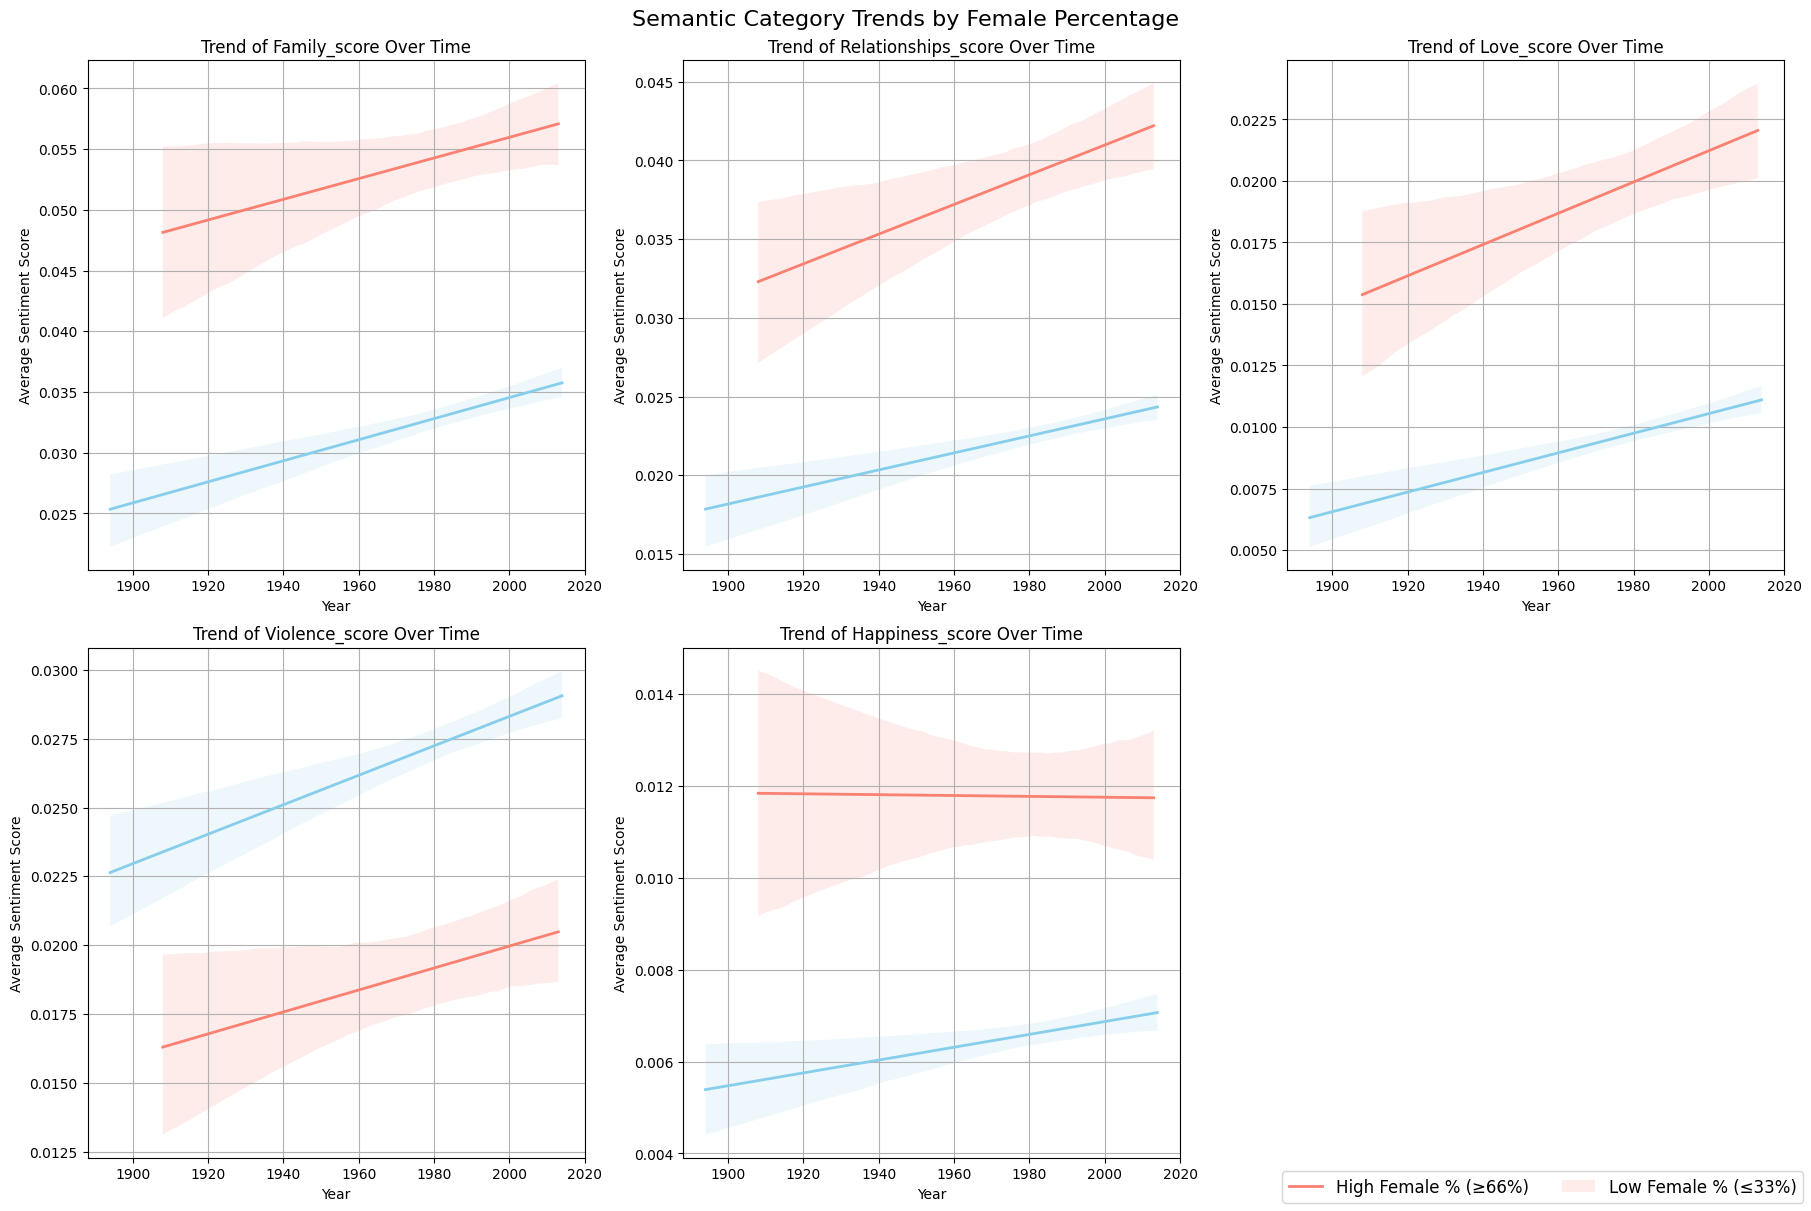

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add a 'Year' column if the release date is in a datetime format
df['Year'] = pd.to_datetime(df['Movie_release_date']).dt.year

# Add a 'Subset' column to differentiate male-majority and female-majority movies
df['Subset'] = df.apply(
    lambda row: 'High Female % (≥66%)' if row['Female Percentage'] >= 66 else (
        'Low Female % (≤33%)' if row['Female Percentage'] <= 33 else None
    ),
    axis=1
)

# Filter out rows not part of the male or female subsets
df_filtered = df[df['Subset'].notnull()]

# Define colors for the subsets
subset_colors = {
    'High Female % (≥66%)': 'salmon',
    'Low Female % (≤33%)': 'skyblue'
}

# Create subplots for all sentiments
num_sentiments = len(top_5_sentiments)  # Replace with `len(sentiment_cols)` if using all sentiments
fig, axes = plt.subplots(
    nrows=(num_sentiments + 2) // 3,
    ncols=3,
    figsize=(18, 12),
    constrained_layout=True
)
axes = axes.flatten()

for idx, sentiment in enumerate(top_5_sentiments):  # Replace with `sentiment_cols` if using all sentiments
    if idx >= len(axes):
        break
    
    # Plot on the specified subplot axis
    for subset, color in subset_colors.items():
        subset_data = df_filtered[df_filtered['Subset'] == subset]
        sns.regplot(
            x='Year',
            y=sentiment,
            data=subset_data,
            scatter=False,
            ax=axes[idx],
            color=color,
            label=subset,
            line_kws={'linewidth': 2}
        )
    
    axes[idx].set_title(f'Trend of {sentiment.replace("_proximity", "").capitalize()} Over Time', fontsize=12)
    axes[idx].set_xlabel('Year', fontsize=10)
    axes[idx].set_ylabel('Average Sentiment Score', fontsize=10)
    axes[idx].grid(visible=True)

# Remove unused subplots
for idx in range(len(top_5_sentiments), len(axes)):
    fig.delaxes(axes[idx])

# Add a legend outside the subplots
fig.legend(
    labels=subset_colors.keys(),
    loc='lower right',
    # bbox_to_anchor=(0.5, 1.02),
    ncol=2,
    fontsize=12
)

# Set the main title for the figure
fig.suptitle('Semantic Category Trends by Female Percentage', fontsize=16)

plt.show()


In [64]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Create the images directory if it doesn't exist
os.makedirs('images', exist_ok=True)

# Assuming df, sentiment_cols, and 'Subset' column are defined as in your original code.
# df contains: 'Year', 'Female Percentage', each sentiment in sentiment_cols, and 'Subset'.
# 'Subset' is either 'High Female % (≥66%)', 'Low Female % (≤33%)', or None.

# Filter only High Female and Low Female subsets
df_filtered = df[df['Subset'].notnull()]

# Define colors for the subsets
subset_colors = {
    'High Female % (≥66%)': 'salmon',
    'Low Female % (≤33%)': 'skyblue'
}

# Generate and save one plot per sentiment
for sentiment in sentiment_cols:
    fig, ax = plt.subplots(figsize=(10,6))

    for subset, color in subset_colors.items():
        subset_data = df_filtered[df_filtered['Subset'] == subset].dropna(subset=[sentiment, 'Year'])
        
        if len(subset_data) > 1:
            sns.regplot(
                x='Year',
                y=sentiment,
                data=subset_data,
                scatter=False,
                ax=ax,
                color=color,
                label=subset,
                line_kws={'linewidth': 2}
            )

    sentiment_label = sentiment.replace("_proximity", "").replace("_score", "").capitalize()
    ax.set_title(f"Trend of {sentiment_label} Over Time")
    ax.set_xlabel("Year")
    ax.set_ylabel("Average Sentiment Score")
    ax.grid(True)
    ax.legend()

    # Save the figure as a PNG file in the images folder
    filename = f"images/{sentiment_label}_trend.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close the figure to free memory

print("All plots saved in the 'images' folder.")


All plots saved in the 'images' folder.


In [65]:
import os

# Directory where the images are stored
image_dir = 'images'

# Get all PNG files in the images directory
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
image_files.sort()  # Sort for consistent ordering if desired

# We'll pick the first image as the default if it exists
default_image = image_files[0] if image_files else ''

# Construct the HTML
html_content = f"""<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8" />
<meta name="viewport" content="width=device-width, initial-scale=1.0"/>
<title>Image Selector</title>
<style>
  body {{ font-family: Arial, sans-serif; margin: 20px; }}
  #image-container {{
    margin-top: 20px;
  }}
  img {{
    max-width: 100%;
    height: auto;
  }}
</style>
</head>
<body>

<h1>Select an Image:</h1>
<select id="imageSelect">
"""

# Add an option for each image
for i, img in enumerate(image_files):
    selected_attr = 'selected' if i == 0 else ''
    html_content += f'  <option value="{image_dir}/{img}" {selected_attr}>{img}</option>\n'

html_content += f"""</select>

<div id="image-container">
  <img id="displayImage" src="{image_dir}/{default_image}" alt="Selected Image"/>
</div>

<script>
  const imageSelect = document.getElementById('imageSelect');
  const displayImage = document.getElementById('displayImage');

  imageSelect.addEventListener('change', function() {{
    const selectedSrc = imageSelect.value;
    displayImage.src = selectedSrc;
  }});
</script>

</body>
</html>
"""

# Save the HTML to a file
with open("image_selector.html", "w", encoding="utf-8") as f:
    f.write(html_content)

print("HTML file created: image_selector.html")


HTML file created: image_selector.html


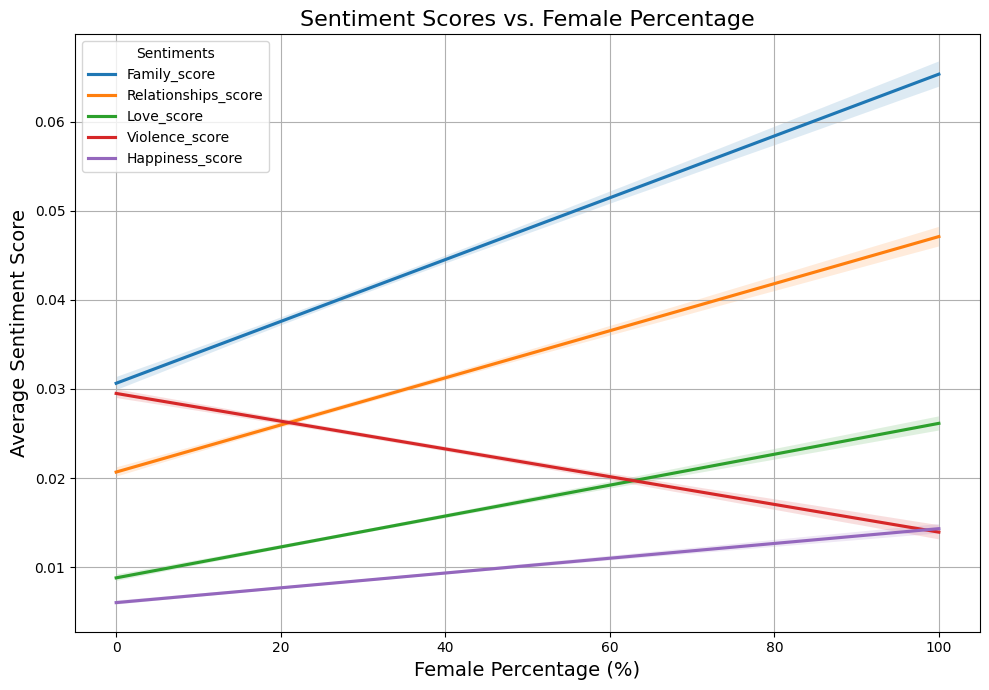

In [63]:
# Initialize the matplotlib figure
plt.figure(figsize=(10, 7))
# Define a color palette for the top 5 sentiments
colors = sns.color_palette("tab10", n_colors=5)

# Loop through each sentiment and plot
for sentiment, color in zip(top_5_sentiments, colors):
    sns.regplot(
        x='Female Percentage',
        y=sentiment,
        data=df,
        scatter=False,
        label=sentiment.replace('_proximity', '').capitalize(),
        color=color,
        # line_kws={'linewidth': 2}
    )

# Customize the plot
plt.xlabel('Female Percentage (%)', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.title('Sentiment Scores vs. Female Percentage', fontsize=16)
plt.legend(title='Sentiments')
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


In [25]:
import pandas as pd
import plotly.express as px

# Add a 'Subset' column to differentiate male-majority and female-majority movies
df['Subset'] = df.apply(
    lambda row: 'High Female % (≥66%)' if row['Female Percentage'] >= 66 else (
        'Low Female % (≤33%)' if row['Female Percentage'] <= 33 else None
    ),
    axis=1
)



df = df.explode('Movie_countries').reset_index(drop=True)

# Geographical analysis of semantic scores
# Separate female-majority and male-majority movies
female_movies = df[df['Subset'] == 'High Female % (≥66%)']
male_movies = df[df['Subset'] == 'Low Female % (≤33%)']

# Define semantic score columns (assuming they end with '_proximity')
sentiment_cols = [col for col in df.columns if col.endswith('_proximity')]

# Group by country and calculate mean scores for female and male subsets
female_country_scores = female_movies.groupby('Movie_countries')[sentiment_cols].mean().reset_index()
male_country_scores = male_movies.groupby('Movie_countries')[sentiment_cols].mean().reset_index()

# Combine the scores into a single DataFrame for comparison
country_comparison = female_country_scores.merge(
    male_country_scores,
    on='Movie_countries',
    how='outer',
    suffixes=('_female', '_male')
)

# Plotting the comparison for a specific sentiment (e.g., "love_proximity")
selected_sentiment = 'family_score_proximity'  # Adjust based on your actual column names

# Prepare data for plotting
data_to_plot_female = country_comparison[['Movie_countries', f'{selected_sentiment}_female']].dropna()
data_to_plot_female.rename(columns={
    'Movie_countries': 'country',
    f'{selected_sentiment}_female': 'Female_Majority_Score'
}, inplace=True)

data_to_plot_male = country_comparison[['Movie_countries', f'{selected_sentiment}_male']].dropna()
data_to_plot_male.rename(columns={
    'Movie_countries': 'country',
    f'{selected_sentiment}_male': 'Male_Majority_Score'
}, inplace=True)


In [26]:
country_comparison

,Movie_countries,love_score_proximity_female,aggression_score_proximity_female,violence_score_proximity_female,family_score_proximity_female,happiness_score_proximity_female,sadness_score_proximity_female,fear_score_proximity_female,empowerment_score_proximity_female,relationships_score_proximity_female,...,empowerment_score_proximity_male,relationships_score_proximity_male,career_score_proximity_male,social_issues_score_proximity_male,emotional_complexity_score_proximity_male,heroism_score_proximity_male,conflict_resolution_score_proximity_male,adventure_score_proximity_male,mystery_score_proximity_male,technology_score_proximity_male
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002901,0.015474,0.010638,0.000967,0.009671,0.001934,0.007737,0.004836,0.008704,0.002901
1,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.086957,0.043478,0.000000,0.000000,0.000000,0.086957,0.043478,0.000000,0.000000
2,Algeria,0.000000,0.052632,0.052632,0.052632,0.000000,0.000000,0.000000,0.052632,0.052632,...,0.003220,0.000641,0.013223,0.018423,0.014492,0.003846,0.026388,0.019834,0.008706,0.000969
3,Argentina,0.024291,0.002204,0.007713,0.069868,0.008420,0.008243,0.005013,0.005208,0.049309,...,0.008295,0.035691,0.027188,0.010610,0.006072,0.008017,0.019523,0.017408,0.017488,0.006464
4,Armenia,0.000000,0.075000,0.075000,0.075000,0.000000,0.000000,0.025000,0.000000,0.000000,...,0.008065,0.076039,0.009848,0.032977,0.010282,0.029379,0.042826,0.013447,0.009848,0.006250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Uruguay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.007178,0.031027,0.033965,0.005159,0.004343,0.004343,0.024230,0.016181,0.015127,0.005159
100,Venezuela,0.004545,0.004545,0.000000,0.058150,0.004545,0.000000,0.000000,0.000000,0.004545,...,0.020038,0.047938,0.015723,0.012008,0.004034,0.009979,0.024157,0.008272,0.023825,0.012008
101,Vietnam,0.043783,0.004566,0.004566,0.138421,0.027211,0.027848,0.018172,0.000000,0.090240,...,0.005291,0.031579,0.015873,0.006154,0.000000,0.014063,0.010582,0.008772,0.014926,0.000000
102,Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.018868,0.075472,0.018868,0.000000,0.000000,0.000000,0.018868,0.018868,0.018868,0.000000


In [27]:

# Create choropleth map for Female-Majority Scores
fig_female = px.choropleth(
    data_to_plot_female,
    locations="country",
    locationmode='country names',
    color="Female_Majority_Score",
    hover_name="country",
    color_continuous_scale="Reds",
    title=f'Female-Majority Movies: {selected_sentiment.replace("_proximity", "").capitalize()} Scores',
)

# Create choropleth map for Male-Majority Scores
fig_male = px.choropleth(
    data_to_plot_male,
    locations="country",
    locationmode='country names',
    color="Male_Majority_Score",
    hover_name="country",
    color_continuous_scale="Blues",
    title=f'Male-Majority Movies: {selected_sentiment.replace("_proximity", "").capitalize()} Scores',
)

# Display the maps side by side using Plotly's subplots
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create subplots
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=(
                        f'Female-Majority Movies: {selected_sentiment.replace("_proximity", "").capitalize()} Scores',
                        f'Male-Majority Movies: {selected_sentiment.replace("_proximity", "").capitalize()} Scores'
                    ),
                    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}]])

# Add Female-Majority map
fig.add_trace(fig_female.data[0], row=1, col=1)

# Add Male-Majority map
fig.add_trace(fig_male.data[0], row=1, col=2)

# Update layout
fig.update_layout(
    title_text=f'Comparison of {selected_sentiment.replace("_proximity", "").capitalize()} Scores by Gender Majority',
    geo=dict(
    showframe=False,
    showcoastlines=True,  # Enables coastlines
    coastlinecolor='black',
    showcountries=True,   # Enables country borders
    countrycolor='black',
    projection_type='equirectangular',  # Change the projection type as needed
    ),
    height=600,
    width=1200
)

fig.show()


In [28]:
data_to_plot = data_to_plot_male.merge(data_to_plot_female, on='country', how='inner')
data_to_plot['Female_majority'] =data_to_plot['Female_Majority_Score'] > data_to_plot['Male_Majority_Score']


In [29]:
data_to_plot

,country,Male_Majority_Score,Female_Majority_Score,Female_majority
0,Algeria,0.060916,0.052632,False
1,Argentina,0.040813,0.069868,True
2,Armenia,0.047190,0.075000,True
3,Australia,0.033791,0.062735,True
4,Austria,0.031318,0.031803,True
...,...,...,...,...
68,United Arab Emirates,0.036892,0.045662,True
69,United Kingdom,0.027355,0.052068,True
70,United States of America,0.027995,0.049746,True
71,Venezuela,0.049841,0.058150,True


In [ ]:
import plotly.express as px

# Create a choropleth map for Female-Majority Scores
fig = px.choropleth(
    data_to_plot,
    locations="country",
    locationmode='country names',
    color="Female_majority",
    hover_name="country",
    hover_data={
        "Male_Majority_Score": True,
        "Female_Majority_Score": True,
        "country":False,

    },
    title=f'Majority Movies: {selected_sentiment.replace("_proximity", "").capitalize()} Scores',
)

# Update layout for space optimization
fig.update_layout(
    title=dict(
        text=f'Majority Movies: {selected_sentiment.replace("_proximity", "").capitalize()} Scores',
        y=0.95,  # Position the title closer to the top edge
        x=0.5,
        xanchor='center',
        yanchor='top',
    ),
    margin=dict(
        l=10,  # Reduce left margin
        r=10,  # Reduce right margin
        t=40,  # Reduce top margin
        b=10   # Reduce bottom margin
    ),
    geo=dict(
        showframe=False,
        showcoastlines=True,
        coastlinecolor='black',
        showcountries=True,
        countrycolor='black',
        projection_type='equirectangular',
    ),
    height=500,  # Optimize figure height
    width=900,   # Optimize figure width
)

# Display the figure
fig.show()


In [31]:
sentiment_cols

['love_score_proximity',
 'aggression_score_proximity',
 'violence_score_proximity',
 'family_score_proximity',
 'happiness_score_proximity',
 'sadness_score_proximity',
 'fear_score_proximity',
 'empowerment_score_proximity',
 'relationships_score_proximity',
 'career_score_proximity',
 'social_issues_score_proximity',
 'emotional_complexity_score_proximity',
 'heroism_score_proximity',
 'conflict_resolution_score_proximity',
 'adventure_score_proximity',
 'mystery_score_proximity',
 'technology_score_proximity']

In [32]:
country_comparison

,Movie_countries,love_score_proximity_female,aggression_score_proximity_female,violence_score_proximity_female,family_score_proximity_female,happiness_score_proximity_female,sadness_score_proximity_female,fear_score_proximity_female,empowerment_score_proximity_female,relationships_score_proximity_female,...,empowerment_score_proximity_male,relationships_score_proximity_male,career_score_proximity_male,social_issues_score_proximity_male,emotional_complexity_score_proximity_male,heroism_score_proximity_male,conflict_resolution_score_proximity_male,adventure_score_proximity_male,mystery_score_proximity_male,technology_score_proximity_male
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002901,0.015474,0.010638,0.000967,0.009671,0.001934,0.007737,0.004836,0.008704,0.002901
1,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.086957,0.043478,0.000000,0.000000,0.000000,0.086957,0.043478,0.000000,0.000000
2,Algeria,0.000000,0.052632,0.052632,0.052632,0.000000,0.000000,0.000000,0.052632,0.052632,...,0.003220,0.000641,0.013223,0.018423,0.014492,0.003846,0.026388,0.019834,0.008706,0.000969
3,Argentina,0.024291,0.002204,0.007713,0.069868,0.008420,0.008243,0.005013,0.005208,0.049309,...,0.008295,0.035691,0.027188,0.010610,0.006072,0.008017,0.019523,0.017408,0.017488,0.006464
4,Armenia,0.000000,0.075000,0.075000,0.075000,0.000000,0.000000,0.025000,0.000000,0.000000,...,0.008065,0.076039,0.009848,0.032977,0.010282,0.029379,0.042826,0.013447,0.009848,0.006250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Uruguay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.007178,0.031027,0.033965,0.005159,0.004343,0.004343,0.024230,0.016181,0.015127,0.005159
100,Venezuela,0.004545,0.004545,0.000000,0.058150,0.004545,0.000000,0.000000,0.000000,0.004545,...,0.020038,0.047938,0.015723,0.012008,0.004034,0.009979,0.024157,0.008272,0.023825,0.012008
101,Vietnam,0.043783,0.004566,0.004566,0.138421,0.027211,0.027848,0.018172,0.000000,0.090240,...,0.005291,0.031579,0.015873,0.006154,0.000000,0.014063,0.010582,0.008772,0.014926,0.000000
102,Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.018868,0.075472,0.018868,0.000000,0.000000,0.000000,0.018868,0.018868,0.018868,0.000000


In [72]:
# Initialize a list to hold all the choropleth traces
data_traces = []

for i, sentiment in enumerate(sentiment_cols):
    # Prepare data for female-majority movies
    data_to_plot_female = country_comparison[['Movie_countries', f'{sentiment}_female']].dropna()
    data_to_plot_female.rename(columns={
        'Movie_countries': 'country',
        f'{sentiment}_female': 'Female_Majority_Score'
    }, inplace=True)

    # Prepare data for male-majority movies
    data_to_plot_male = country_comparison[['Movie_countries', f'{sentiment}_male']].dropna()
    data_to_plot_male.rename(columns={
        'Movie_countries': 'country',
        f'{sentiment}_male': 'Male_Majority_Score'
    }, inplace=True)

    # Merge female and male data
    data_to_plot = data_to_plot_male.merge(data_to_plot_female, on='country', how='inner')
    data_to_plot['Female_majority'] = data_to_plot['Female_Majority_Score'] > data_to_plot['Male_Majority_Score']
    
    # Define a custom color scale based on the Female_majority column
    data_to_plot['color'] = data_to_plot['Female_majority'].apply(lambda x: 'salmon' if x else 'skyblue')

    # Create custom hovertext
    data_to_plot['hover_text'] = (
        "Country: " + data_to_plot['country'] +
        "<br>Male Majority Score: " + data_to_plot['Male_Majority_Score'].astype(str) +
        "<br>Female Majority Score: " + data_to_plot['Female_Majority_Score'].astype(str) +
        "<br>Sentiment: " + sentiment
    )

    # Update the trace
    choropleth_trace = go.Choropleth(
        locations=data_to_plot['country'],
        locationmode='country names',
        z=data_to_plot['Female_majority'].astype(int),
        colorscale=[[0, 'skyblue'], [1, 'salmon']],
        showscale=False,  # Disable the color bar
        text=data_to_plot['hover_text'],  # Use custom hover text
        hoverinfo='text'  # Display only the custom hover text
    )
    data_traces.append(choropleth_trace)


In [73]:
# Create dropdown menu buttons
buttons = []
for i, sentiment in enumerate(sentiment_cols):
    button = dict(
        label=sentiment.replace("_proximity", "").capitalize(),
        method='update',
        args=[
            {'visible': [j == i for j in range(len(sentiment_cols))]},  # Toggle visibility
            {'title': f'Majority Movies: {sentiment.replace("_proximity", "").capitalize()} Scores'}
        ]
    )
    buttons.append(button)


In [86]:
# Layout with improved legend
layout = go.Layout(
    title=f'Majority Movies: {sentiment_cols[0].replace("_proximity", "").capitalize()} Scores',
    updatemenus=[dict(
        buttons=buttons,
        direction='down',
        showactive=True,
        x=0.5,
        y=1.15,
        xanchor='left',
        yanchor='top'
    )],
    geo=dict(
        showframe=False,
        showcoastlines=True,
        coastlinecolor='black',
        showcountries=True,
        countrycolor='black',
        projection_type='equirectangular',
    ),
    margin=dict(l=10, r=10, t=100, b=10),
    height=600,
    width=1000,
    annotations=[
        dict(
            x=0.05,  # Position for "Female Majority"
            y=1.02,
            xref="paper",
            yref="paper",
            text='<span style="color:salmon;">&#9632;</span> Female Majority',
            showarrow=False,
            font=dict(size=12),
        ),
        dict(
            x=0.05,  # Position for "Not Female Majority"
            y=0.98,
            xref="paper",
            yref="paper",
            text='<span style="color:skyblue;">&#9632;</span> Male Majority',
            showarrow=False,
            font=dict(size=12),
        ),
    ],
)



In [89]:
# Create the figure with all traces and the defined layout
fig = go.Figure(data=data_traces, layout=layout)

# Display the interactive figure
fig.show()

# Save the figure as an HTML file
fig.write_html("geographic_sentiment_score.html")
